# Filter Visualization in Pytorch

## Mount Filesystem

In [1]:
GOOGLE = False
if GOOGLE:
    from google.colab import drive
    drive.mount('/content/drive')

## Check For Devices

In [2]:
# @title GPU code
import torch
import torch.nn.functional as F

# Define the device to use for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Please set GPU via Edit -> Notebook Settings.


## Data Pre-processing

In [3]:
import numpy as np
def train_data_prep(X,y,sub_sample,average,noise, cutoff):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:cutoff]

    # print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    # print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    # print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X, sub_sample, timestop):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:timestop]
    # print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    # print('Shape of X after maxpooling:',total_X.shape)

    return total_X


## Training and Evaluation Function Definition

In [4]:
import os
import random

import numpy as np
import torch
from tqdm import tqdm

from matplotlib import pyplot as plt

# Also, seed everything for reproducibility
# code from https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964#file-seed_everything-py
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


def train(model, train_loader, val_loader, optimizer, criterion, device,
          num_epochs):
    """
    Train the MLP classifier on the training set and evaluate it on the validation set every epoch.

    Args:
        model (MLP): MLP classifier to train.
        train_loader (torch.utils.data.DataLoader): Data loader for the training set.
        val_loader (torch.utils.data.DataLoader): Data loader for the validation set.
        optimizertimestop (torch.optim.Optimizer): Optimizer to use for training.
        criterion (callable): Loss function to use for training.
        device (torch.device): Device to use for training.
        num_epochs (int): Number of epochs to train the model.
    """
    # Place model on device
    model = model.to(device)
    loss_history_train = []
    loss_history_val = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        # Use tqdm to display a progress bar during training
        with tqdm(total=len(train_loader),
                  desc=f'Epoch {epoch + 1}/{num_epochs}',
                  position=0,
                  leave=True) as pbar:
            for inputs, labels in train_loader:
                # Move inputs and labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero out gradients
                optimizer.zero_grad()

                # Compute the logits and loss
                logits = model(inputs.float())
                loss = criterion(logits, labels)

                # Backpropagate the loss
                loss.backward()

                # Update the weights
                optimizer.step()

                # Update the progress bar
                pbar.update(1)
                pbar.set_postfix(loss=loss.item())

        # Evaluate the model on the validation set
        avg_loss, accuracy = evaluate(model, val_loader, criterion, device)
        loss_history_val.append(accuracy)
        print(
            f'Validation set: Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}'
        )
        avg_loss_train, accuracy_train = evaluate(model, train_loader, criterion, device)
        print(
            f'Training set: Average loss = {avg_loss_train:.4f}, Accuracy = {accuracy_train:.4f}'
        )
        loss_history_train.append(accuracy_train)
    plt.plot(loss_history_val)
    plt.plot(loss_history_train)
    plt.show()
    return loss_history_train, loss_history_val
def evaluate(model, test_loader, criterion, device):
    """
    Evaluate the MLP classifier on the test set.

    Args:
        model (MLP): MLP classifier to evaluate.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        criterion (callable): Loss function to use for evaluation.
        device (torch.device): Device to use for evaluation.

    Returns:
        float: Average loss on the test set.
        float: Accuracy on the test set.
    """
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        total_loss = 0.0
        num_correct = 0
        num_samples = 0

        for inputs, labels in test_loader:
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Compute the logits and loss
            logits = model(inputs.float())
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Compute the accuracy
            _, predictions = torch.max(logits, dim=1)
            num_correct += (predictions == labels).sum().item()
            num_samples += len(inputs)

    # Compute the average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    accuracy = num_correct / num_samples

    return avg_loss, accuracy

## EEG Dataset Class

In [5]:
# @title EEG DATA
import os
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
import pandas as pd

class EEG_Data(Dataset):

    def __init__(self, root_dir, split, preprocess=lambda x,y:train_data_prep(x,y,2,2,True), transform=None, label_dict=None):
        """
        Initialize the eeg dataset with the root directory for the images,
        the split (train/val/test), an optional data transformation,
        and an optional label dictionary.

        Args:
            root_dir (str): Root directory for the eeg images.
            split (str): Split to use ('train', 'val', or 'test').
            transform (callable, optional): Optional data transformation to apply to the images.
            label_dict (dict, optional): Optional dictionary mapping integer labels to class names.
        """
        assert split in ['train', 'val', 'test']
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.datastorch = []
        self.labels = []
        self.label_dict = ["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"]

        ################# Your Implementations #################################
        if self.split == 'train':
            # First generating the training and validation indices using random splitting
            X_train_valid = np.load(self.root_dir+"X_train_valid.npy")
            y_train_valid = np.load(self.root_dir+"y_train_valid.npy")

            np.random.seed(0)
            data_length = len(X_train_valid)

            ind_valid = np.random.choice(data_length, int(data_length*0.1), replace=False)
            ind_train = np.array(list(set(range(data_length)).difference(set(ind_valid))))

            # Creating the training and validation sets using the generated indices
            (x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
            (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

            if preprocess is not None:
                x_train,y_train = preprocess(x_train,y_train)

            self.datas = torch.from_numpy(x_train)
            self.labels = [int(i-769) for i in torch.from_numpy(y_train)]

        if self.split == 'val':
            # First generating the training and validation indices using random splitting
            X_train_valid = np.load(self.root_dir+"X_train_valid.npy")
            y_train_valid = np.load(self.root_dir+"y_train_valid.npy")

            data_length = len(X_train_valid)

            np.random.seed(0)
            ind_valid = np.random.choice(data_length, int(data_length*0.1), replace=False)
            ind_train = np.array(list(set(range(data_length)).difference(set(ind_valid))))

            # Creating the training and validation sets using the generated indices
            (x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
            (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

            if preprocess is not None:
                x_valid,y_valid = preprocess(x_valid,y_valid)

            self.datas = torch.from_numpy(x_valid)
            self.labels = [int(i-769) for i in torch.from_numpy(y_valid)]

        if self.split == 'test':
            x_test = np.load(self.root_dir+"X_test.npy")
            # x_test = test_data_prep(x_test_og)  # (2115, 1)  vals from 0-8 for participant
            if preprocess is not None:
                x_test = preprocess(x_test)
            y_test = np.load(self.root_dir+"y_test.npy")  # (443, 1)
            self.datas = torch.from_numpy(x_test)
            self.labels = [int(i-769) for i in torch.from_numpy(y_test)]

        ################# End of your Implementations ##########################

    def __len__(self):
        """
        Return the number of images in the dataset.

        Returns:
            int: Number of images in the dataset.
        """
        dataset_len = 0
        ################# Your Implementations #################################
        # Return the number of images in the dataset
        dataset_len = len(self.datas)
        ################# End of your Implementations ##########################
        return dataset_len

    def __getitem__(self, idx):
        """
        R10140    idx (int): Index of the image to retrieve.

        Returns:
            tuple: Tuple containing the image and its label.
        """
        ################# Your Implementations #################################
        # Load and preprocess image using self.root_dir,
        # self.filenames[idx], and self.transform (if specified)

        data = self.datas[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(data)
        ################# End of your Implementations ##########################
        return data, label

# 22 Channel Kernels

## EEGNet Torch Implementation

In [30]:
# @title  EEGNet 800/22
# This is EEGNet from https://arxiv.org/abs/1611.08024

# This is EEGNet from https://arxiv.org/abs/1611.08024
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm


class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()

        self.F1 = 8
        self.F2 = 16
        self.D = 2

        # Conv2d(in,out,kernel,stride,padding,bias)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, 64), padding=(0, 32), bias=False),
            nn.BatchNorm2d(self.F1)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.F1, self.D*self.F1, (22, 1), groups=self.F1, bias=False),
            nn.BatchNorm2d(self.D*self.F1),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.5)
        )

        self.Conv3 = nn.Sequential(
            nn.Conv2d(self.D*self.F1, self.D*self.F1, (1, 16), padding=(0, 8), groups=self.D*self.F1, bias=False),
            nn.Conv2d(self.D*self.F1, self.F2, (1, 1), bias=False),
            nn.BatchNorm2d(self.F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(0.5)
        )
        self.flatten = nn.Flatten(start_dim=1)
        self.classifier = nn.Linear(192, 4, bias=True)

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.Conv3(x)

        x = self.flatten(x)
        x = self.classifier(x)
        return x


## Loading Model

In [7]:
all_result = {}

In [32]:
import json
# @title Data loading
cutoff = 800
data_root = "../project_data/project/"
if GOOGLE:
    data_root = "/contentimestopt/drive/MyDrive/project/"
data_transform =  lambda x: (x.reshape(1, x.shape[0],x.shape[1]))
preprocess = lambda x,y:train_data_prep(x,y,2,2,True, cutoff)
# Create eeg dataset object
eeg_train = EEG_Data(data_root,
                            split='train',
                            preprocess=preprocess,
                            transform=data_transform)

eeg_val = EEG_Data(data_root,
                        split='val',
                        preprocess=preprocess,
                        transform=data_transform)
eeg_test = EEG_Data(data_root,
                        split='test',
                        preprocess=lambda x:test_data_prep(x, 2, cutoff),
                        transform=data_transform)
print("val split: ", len(eeg_val))
print("train split: ", len(eeg_train))
print(eeg_train[0][0].shape)
print(eeg_train[0][0][:,0:18,:].shape)
# Create the dataloaders
# Define the batch size and number of workers
batch_size = 64
num_workers=2
# Create DataLoader for trainimport torch
train_loader = DataLoader(eeg_train,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        shuffle=True)
val_loader = DataLoader(eeg_val,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        shuffle=False)
test_loader = DataLoader(eeg_test,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        shuffle=False)

seed_everything(0)


model = EEGNet()
model.load_state_dict(torch.load("./800_22.zip"))

# Let's test_loaderss function, your implementation and the built-in loss function should
# be almost identical.
criterion = nn.CrossEntropyLoss()
avg_loss, accuracy = evaluate(model, test_loader, criterion, device)

json.dump(all_result, open("./results.json", "w"))
print("avg_loss", avg_loss)
print("accuracy", accuracy)



Shape of X after subsampling and concatenating: (7616, 22, 400)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 400)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 400])
torch.Size([1, 18, 400])


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

## Visualize Kernels

RuntimeError: shape '[16, 22]' is invalid for input of size 288

<Figure size 640x480 with 0 Axes>

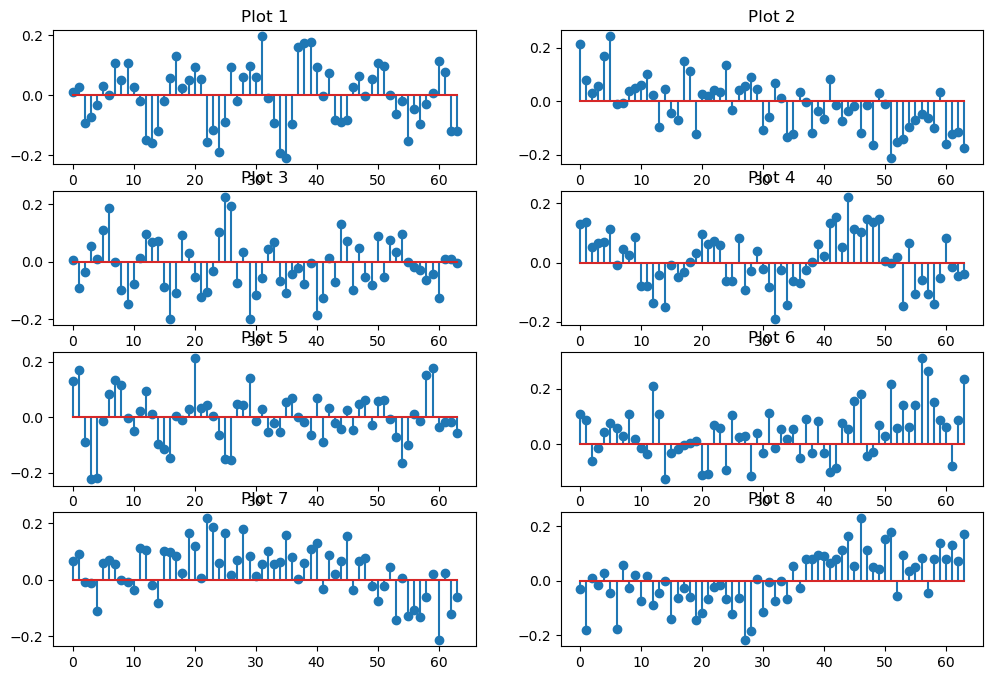

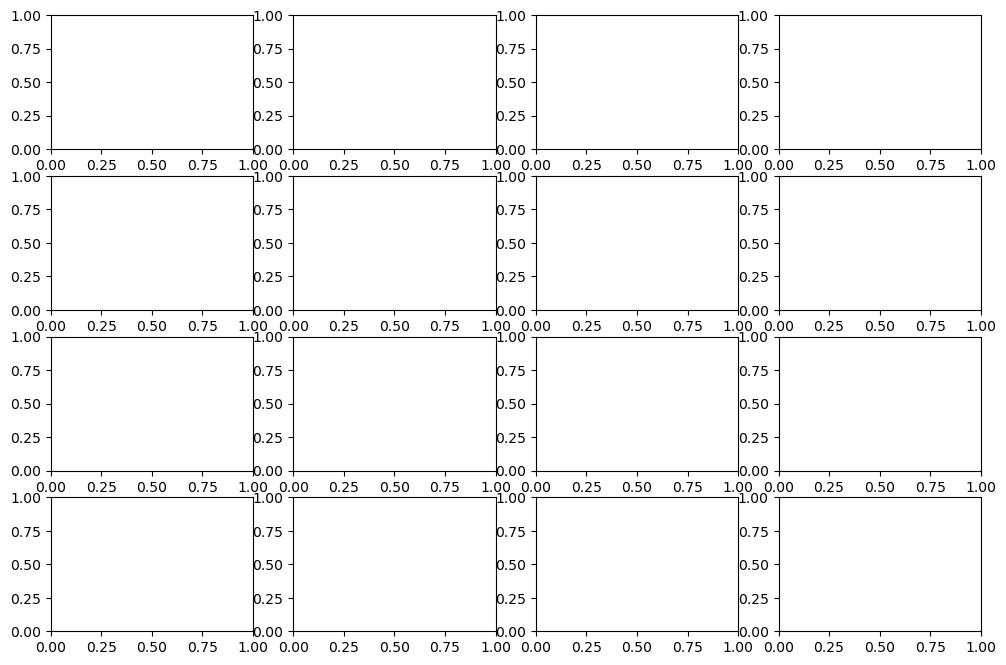

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils
from matplotlib.pyplot import figure


figure(figsize=(8, 6), dpi=80)
def visTensor(tensor, ch=0, allkernels=False, nrow=1, padding=1): 
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    

    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    # plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))




filter = model.conv1[0].weight.data.clone()
# Create subplots with a 4x3 grid
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 8))
# Flatten the axes array to iterate over all subplots
axes = axes.flatten()
# Plot data on each subplot
for i, ax in enumerate(axes):
    curr = filter.reshape(8,64)[i]
    ax.stem(curr)  # Plot your data here or replace it with your own plotting function
    ax.set_title(f'Plot {i+1}')  # Set title for each subplot


filter = model.conv2[0].weight.data.clone()
# Create subplots with a 4x3 grid
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 8))
# Flatten the axes array to iterate over all subplots
axes = axes.flatten()
# Plot data on each subplot
a = np.zeros((1,22))
for i, ax in enumerate(axes):
    curr = filter.reshape(16,22)[i]
    a = a + np.array(curr).reshape(1,22)
    ax.stem(curr)  # Plot your data here or replace it with your own plotting function
    ax.set_title(f'Plot {i+1}')  # Set title for each subplot

print("Mean weight of different channel across filters: ")
print(np.mean(a, axis=0))

filter = model.Conv3[0].weight.data.clone()
# Create subplots with a 4x3 grid
print(filter.shape)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 8))
# Flatten the axes array to iterate over all subplots
axes = axes.flatten()
# Plot data on each subplot
for i, ax in enumerate(axes):
    ax.stem(filter.reshape(16,16)[i])  # Plot your data here or replace it with your own plotting function
    ax.set_title(f'Plot {i+1}')  # Set title for each subplot

# [1.80347031 1.32788151 1.77502017 1.88213117 1.40445977 1.50014806
#  1.67243442 1.69117117 1.81683595 2.16180894 1.45572001 1.67966913
#  1.75883379 2.18348467 1.88184573 1.61057948 1.56348837 2.24669548
#  2.63736276 2.10104541 1.15771496 2.45669165]

# [1.81521975 2.20453673 1.13048339 1.9138944  1.94878463 1.58974244
#  1.83354492 2.72069706 1.22239803 1.93029268 2.039481   1.67501225
#  2.15077968 2.75300542 2.38481967 2.7136578  1.7379709  2.7754062 ]

In [10]:

avg_loss, accuracy = evaluate(model, test_loader, criterion, device)

print("avg_loss", avg_loss)
print("accuracy", accuracy)


avg_loss 0.8423760533332825
accuracy 0.672686230248307


# 18 Channel Kernel

## 18 Channel EEGNet

In [15]:
# This is EEGNet from https://arxiv.org/abs/1611.08024
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class EEGNet(nn.Module):
    def __init__(self, cutoff):
        super(EEGNet, self).__init__()

        self.F1 = 8
        self.F2 = 16
        self.D = 2

        # Conv2d(in,out,kernel,stride,padding,bias)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, 64), padding=(0, 32), bias=False),
            nn.BatchNorm2d(self.F1)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.F1, self.D*self.F1, (18, 1), groups=self.F1, bias=False),
            nn.BatchNorm2d(self.D*self.F1),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.5)
        )

        self.Conv3 = nn.Sequential(
            nn.Conv2d(self.D*self.F1, self.D*self.F1, (1, 16), padding=(0, 8), groups=self.D*self.F1, bias=False),
            nn.Conv2d(self.D*self.F1, self.F2, (1, 1), bias=False),
            nn.BatchNorm2d(self.F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(0.5)
        )

        self.flatten = nn.Flatten(start_dim=1)
        self.classifier = nn.Linear(480, 4, bias=True)

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.Conv3(x)

        x = self.flatten(x)
        x = self.classifier(x)
        return x


## Load 18channel pretrained EEGnet

In [20]:
import json
# @title Data loading
cutoff = 400
data_root = "../project_data/project/"
if GOOGLE:
    data_root = "/contentimestopt/drive/MyDrive/project/"
data_transform =  lambda x: (x.reshape(1, x.shape[0],x.shape[1]))
preprocess = lambda x,y:train_data_prep(x,y,2,2,True, cutoff)
# Create eeg dataset object
eeg_train = EEG_Data(data_root,
                            split='train',
                            preprocess=preprocess,
                            transform=data_transform)

eeg_val = EEG_Data(data_root,
                        split='val',
                        preprocess=preprocess,
                        transform=data_transform)
eeg_test = EEG_Data(data_root,
                        split='test',
                        preprocess=lambda x:test_data_prep(x, 2, cutoff),
                        transform=data_transform)
print("val split: ", len(eeg_val))
print("train split: ", len(eeg_train))
print(eeg_train[0][0].shape)
print(eeg_train[0][0][:,0:18,:].shape)
# Create the dataloaders
# Define the batch size and number of workers
batch_size = 64
num_workers=2
# Create DataLoader for trainimport torch
train_loader = DataLoader(eeg_train,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        shuffle=True)
val_loader = DataLoader(eeg_val,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        shuffle=False)
test_loader = DataLoader(eeg_test,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        shuffle=False)

seed_everything(0)


model = EEGNet(cutoff)
model.load_state_dict(torch.load("./acc_vs_time/"+str(cutoff)+".zip"))

# Let's test_loaderss function, your implementation and the built-in loss function should
# be almost identical.
criterion = nn.CrossEntropyLoss()
avg_loss, accuracy = evaluate(model, test_loader, criterion, device)

json.dump(all_result, open("./results.json", "w"))
print("avg_loss", avg_loss)
print("accuracy", accuracy)



Shape of X after subsampling and concatenating: (7616, 22, 200)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 200)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 200])
torch.Size([1, 18, 200])
avg_loss 0.7750040973935809
accuracy 0.7110609480812641


## Visualize Kernels

Mean weight of different channel across filters: 
[ 0.49163411  0.76419182 -0.66291404 -0.56296805  0.74927684 -0.45684228
  0.42103665 -0.56111758 -0.14562331  0.67284652  0.43547152 -0.51552552
 -0.42599206 -0.46995967  0.63720266  0.13186831 -1.08041313  0.54241204]
torch.Size([16, 1, 1, 16])


<Figure size 640x480 with 0 Axes>

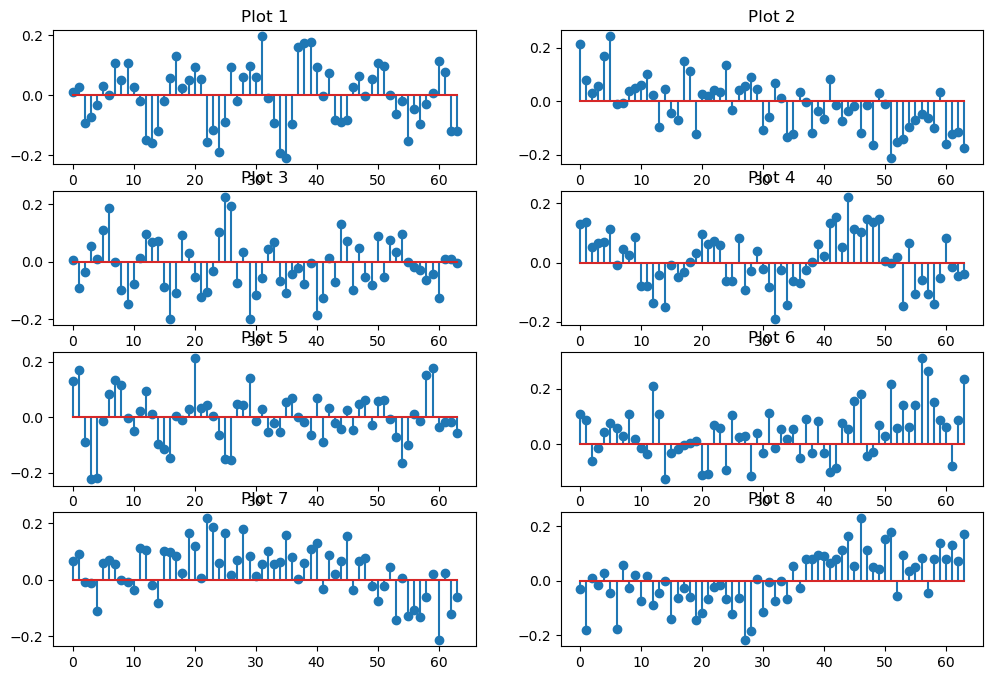

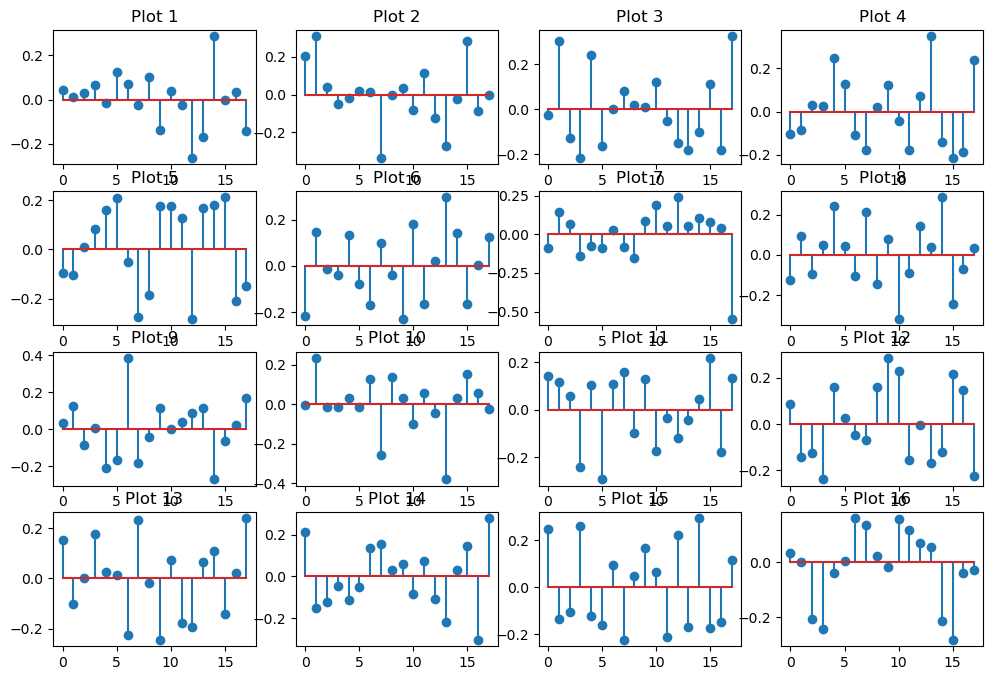

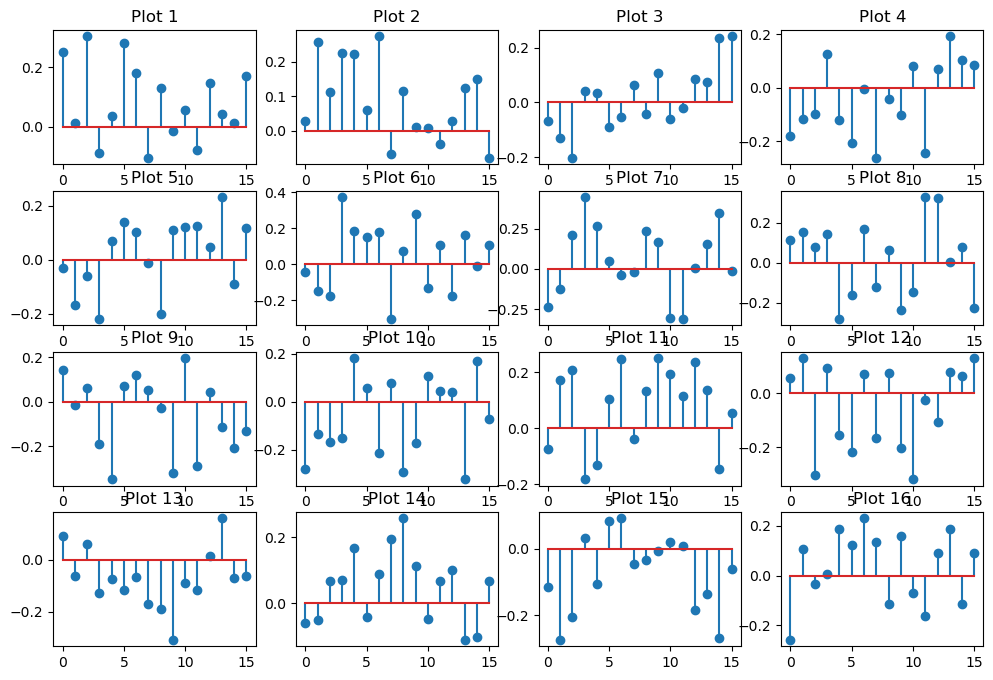

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils
from matplotlib.pyplot import figure


figure(figsize=(8, 6), dpi=80)
def visTensor(tensor, ch=0, allkernels=False, nrow=1, padding=1): 
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    

    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    # plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))




filter = model.conv1[0].weight.data.clone()
# Create subplots with a 4x3 grid
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 8))
# Flatten the axes array to iterate over all subplots
axes = axes.flatten()
# Plot data on each subplot
for i, ax in enumerate(axes):
    curr = filter.reshape(8,64)[i]
    ax.stem(curr)  # Plot your data here or replace it with your own plotting function
    ax.set_title(f'Plot {i+1}')  # Set title for each subplot


filter = model.conv2[0].weight.data.clone()
# Create subplots with a 4x3 grid
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 8))
# Flatten the axes array to iterate over all subplots
axes = axes.flatten()
# Plot data on each subplot
a = np.zeros((1,18))
for i, ax in enumerate(axes):
    curr = filter.reshape(16,18)[i]
    a = a + np.array(curr).reshape(1,18)
    ax.stem(curr)  # Plot your data here or replace it with your own plotting function
    ax.set_title(f'Plot {i+1}')  # Set title for each subplot

print("Mean weight of different channel across filters: ")
print(np.mean(a, axis=0))

filter = model.Conv3[0].weight.data.clone()
# Create subplots with a 4x3 grid
print(filter.shape)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 8))
# Flatten the axes array to iterate over all subplots
axes = axes.flatten()
# Plot data on each subplot
for i, ax in enumerate(axes):
    ax.stem(filter.reshape(16,16)[i])  # Plot your data here or replace it with your own plotting function
    ax.set_title(f'Plot {i+1}')  # Set title for each subplot



# Adjust layout
